# Script

In [1]:
### imports
import os # miscellaneous operating system interfaces
import subprocess # spawn new processes
import nltk # natural language toolkit, http://www.nltk.org/
from nltk.corpus import stopwords # high-frequency words like the, to and also
from collections import Counter # dict subclass for counting hashable objects

### user options
# environments to skip during the detex process
enviros = 'align,vAlgorithm,tikzpicture,subfigure,gather,gathered,lstlisting,tabular,subequations,blankenv'
# working directory (i.e., location of main .tex file)
path = os.path.normpath('/home/leachl/Documents/Thesis/')
# name of the main .tex file
inputfiles = ['Introduction/Introduction.tex','Ch2/Ch2.tex','Ch3/Ch3.tex','Ch4/Ch4.tex','Ch5/Ch5.tex','Discussion/Discussion.tex']

### detex the files
# create the command string
command = 'detex -w -l -e ' + enviros + ' ' + ' '.join(inputfiles)
# run the detex command
text = subprocess.check_output(command, cwd=path, shell=True)

### clean up the text
# break the text into words
content = text.split()
# change the encoding
content = [x.decode("utf-8") for x in content]
# lowercase
content = [x.lower() for x in content]
# remove certain characters
content = [x.replace(')', '') for x in content]
content = [x.replace('(', '') for x in content]
content = [x.replace('-', '') for x in content]
content = [x.replace('"', '') for x in content]
# lemmatize the words (bring to a common form)
wnl = nltk.WordNetLemmatizer()
content = [wnl.lemmatize(word) for word in content]
# remove the high-frequency words
s = set(stopwords.words('english'))
content = filter(lambda w: not w in s, content)
# create a list of words and their frequency
c = Counter(content)
# print the list of words
for key, value in c.most_common(): print(value, key)

519 event
486 model
445 extreme
439 forecast
337 ensemble
335 climate
312 attribution
231 weather
226 approach
209 change
194 based
192 used
181 study
174 temperature
170 heatwave
164 winter
159 would
156 time
140 could
134 mean
131 co
128 simulation
126 wa
126 using
121 system
121 impact
120 lead
118 ha
115 question
113 result
111 condition
110 ukcp
104 future
104 use
103 influence
97 figure
95 within
94 probability
93 chapter
92 estimate
92 initial
90 due
86 global
86 member
85 distribution
85 operational
84 specific
82 ocean
81 however
77 counterfactual
77 perturbation
76 day
75 human
75 anthropogenic
75 large
74 may
74 one
74 analysis
74 exsamples
73 methodology
73 period
73 atmosphere
72 also
72 level
72 experiment
70 able
68 region
68 ppe
67 scale
67 two
67 difference
66 increase
63 present
63 state
63 show
61 provide
61 warming
60 observed
59 thesis
59 different
59 case
59 line
58 range
58 since
58 possible
58 uncertainty
57 key
57 projection
57 sst
57 maximum
56 probabilistic
5

# Create figure

In [2]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import regionmask
import pyproj

from moarpalettes import get_palette

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')
## textwidth of Thesis
textwidth = 5.848611111111111

%matplotlib inline

In [3]:
wordcloud_dict = dict(zip([x[0] for x in c.most_common()],[x[1] for x in c.most_common()]))

In [4]:
img_width = textwidth
img_dpi = 1200
pix_width = int(img_dpi*textwidth)
img_aspect = 1/2
pix_height = int(pix_width*img_aspect)

## create projection transformer

crs = pyproj.CRS("esri:54009")
transformer = pyproj.Transformer.from_crs(crs.geodetic_crs, crs, always_xy=True)
X_min,Y_min,X_max,Y_max = transformer.transform_bounds(*crs.area_of_use.bounds)
transformer1 = pyproj.Transformer.from_crs('esri:54009','epsg:4326',always_xy=True)
x,y = np.meshgrid(np.linspace(X_min,X_max,pix_width),np.linspace(Y_min,Y_max,pix_height))
lons,lats = transformer1.transform(x,y)

## and corresponding land-sea mask
lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(lons,lats).expand_dims({'rgba':['R','G','B','A']},axis=2)
lsm = xr.where(lsm.isnull(),[255,255,255,255],[0,0,0,0])

/home/leachl/miniconda3/lib/python3.7/site-packages/regionmask/core/utils.py:61: RuntimeWarning: invalid value encountered in remainder
  return np.mod(lon, 360)


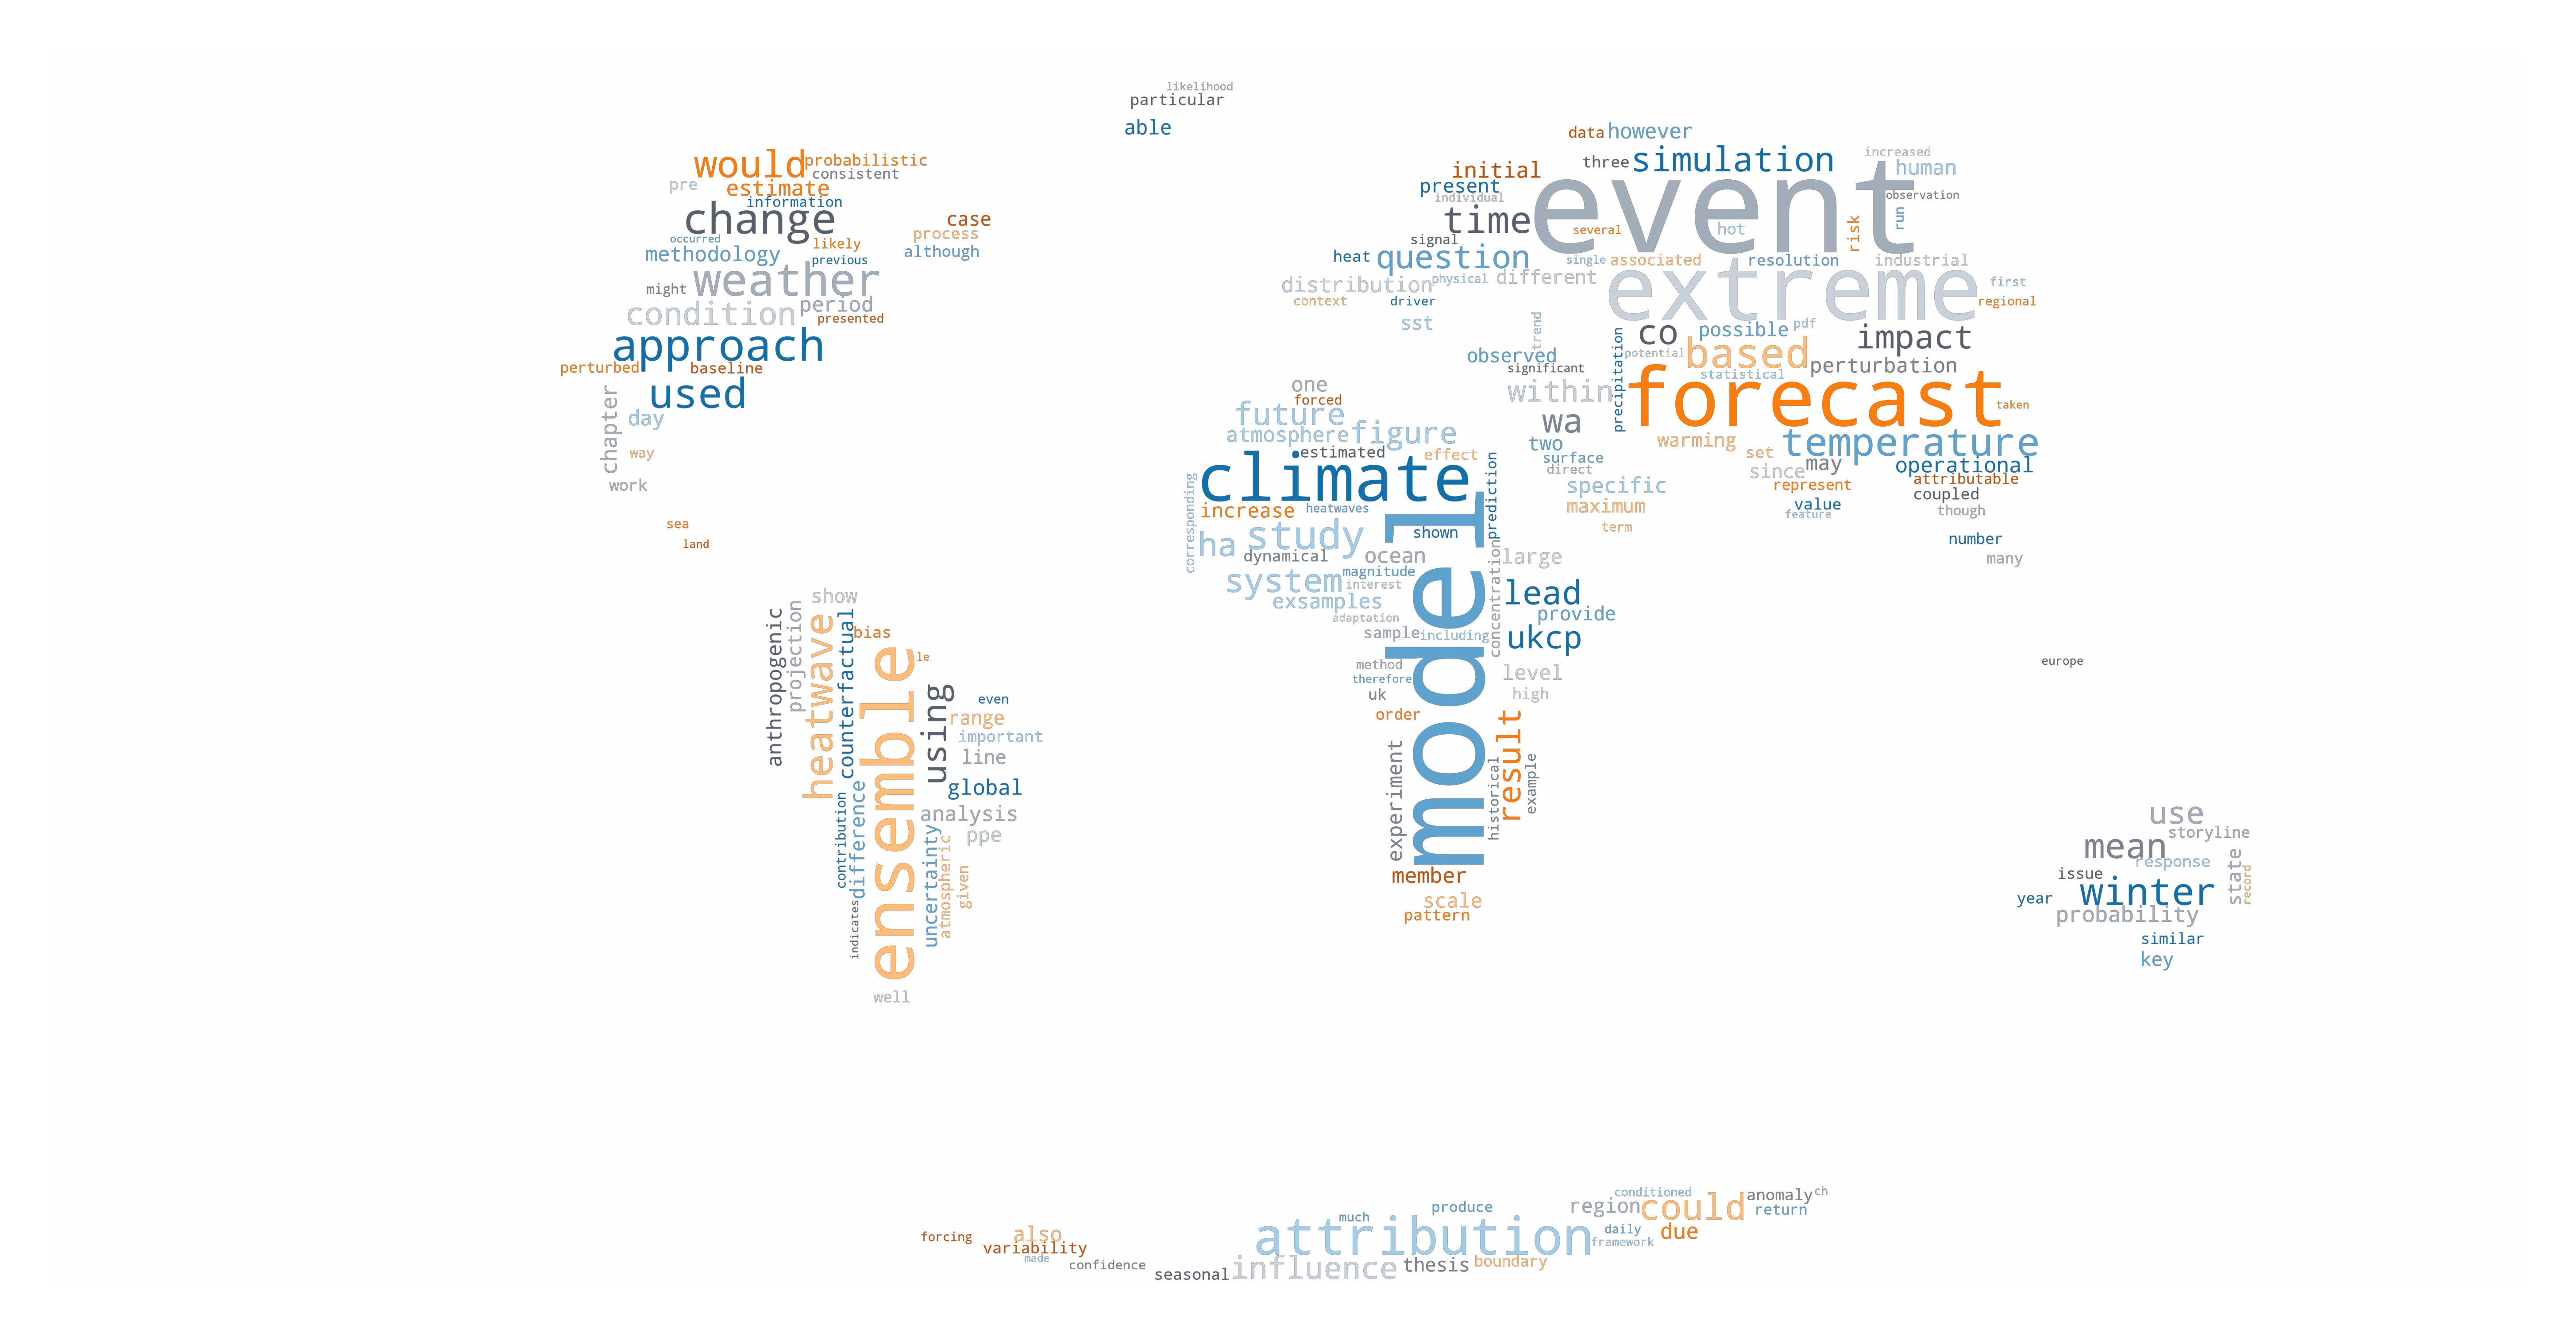

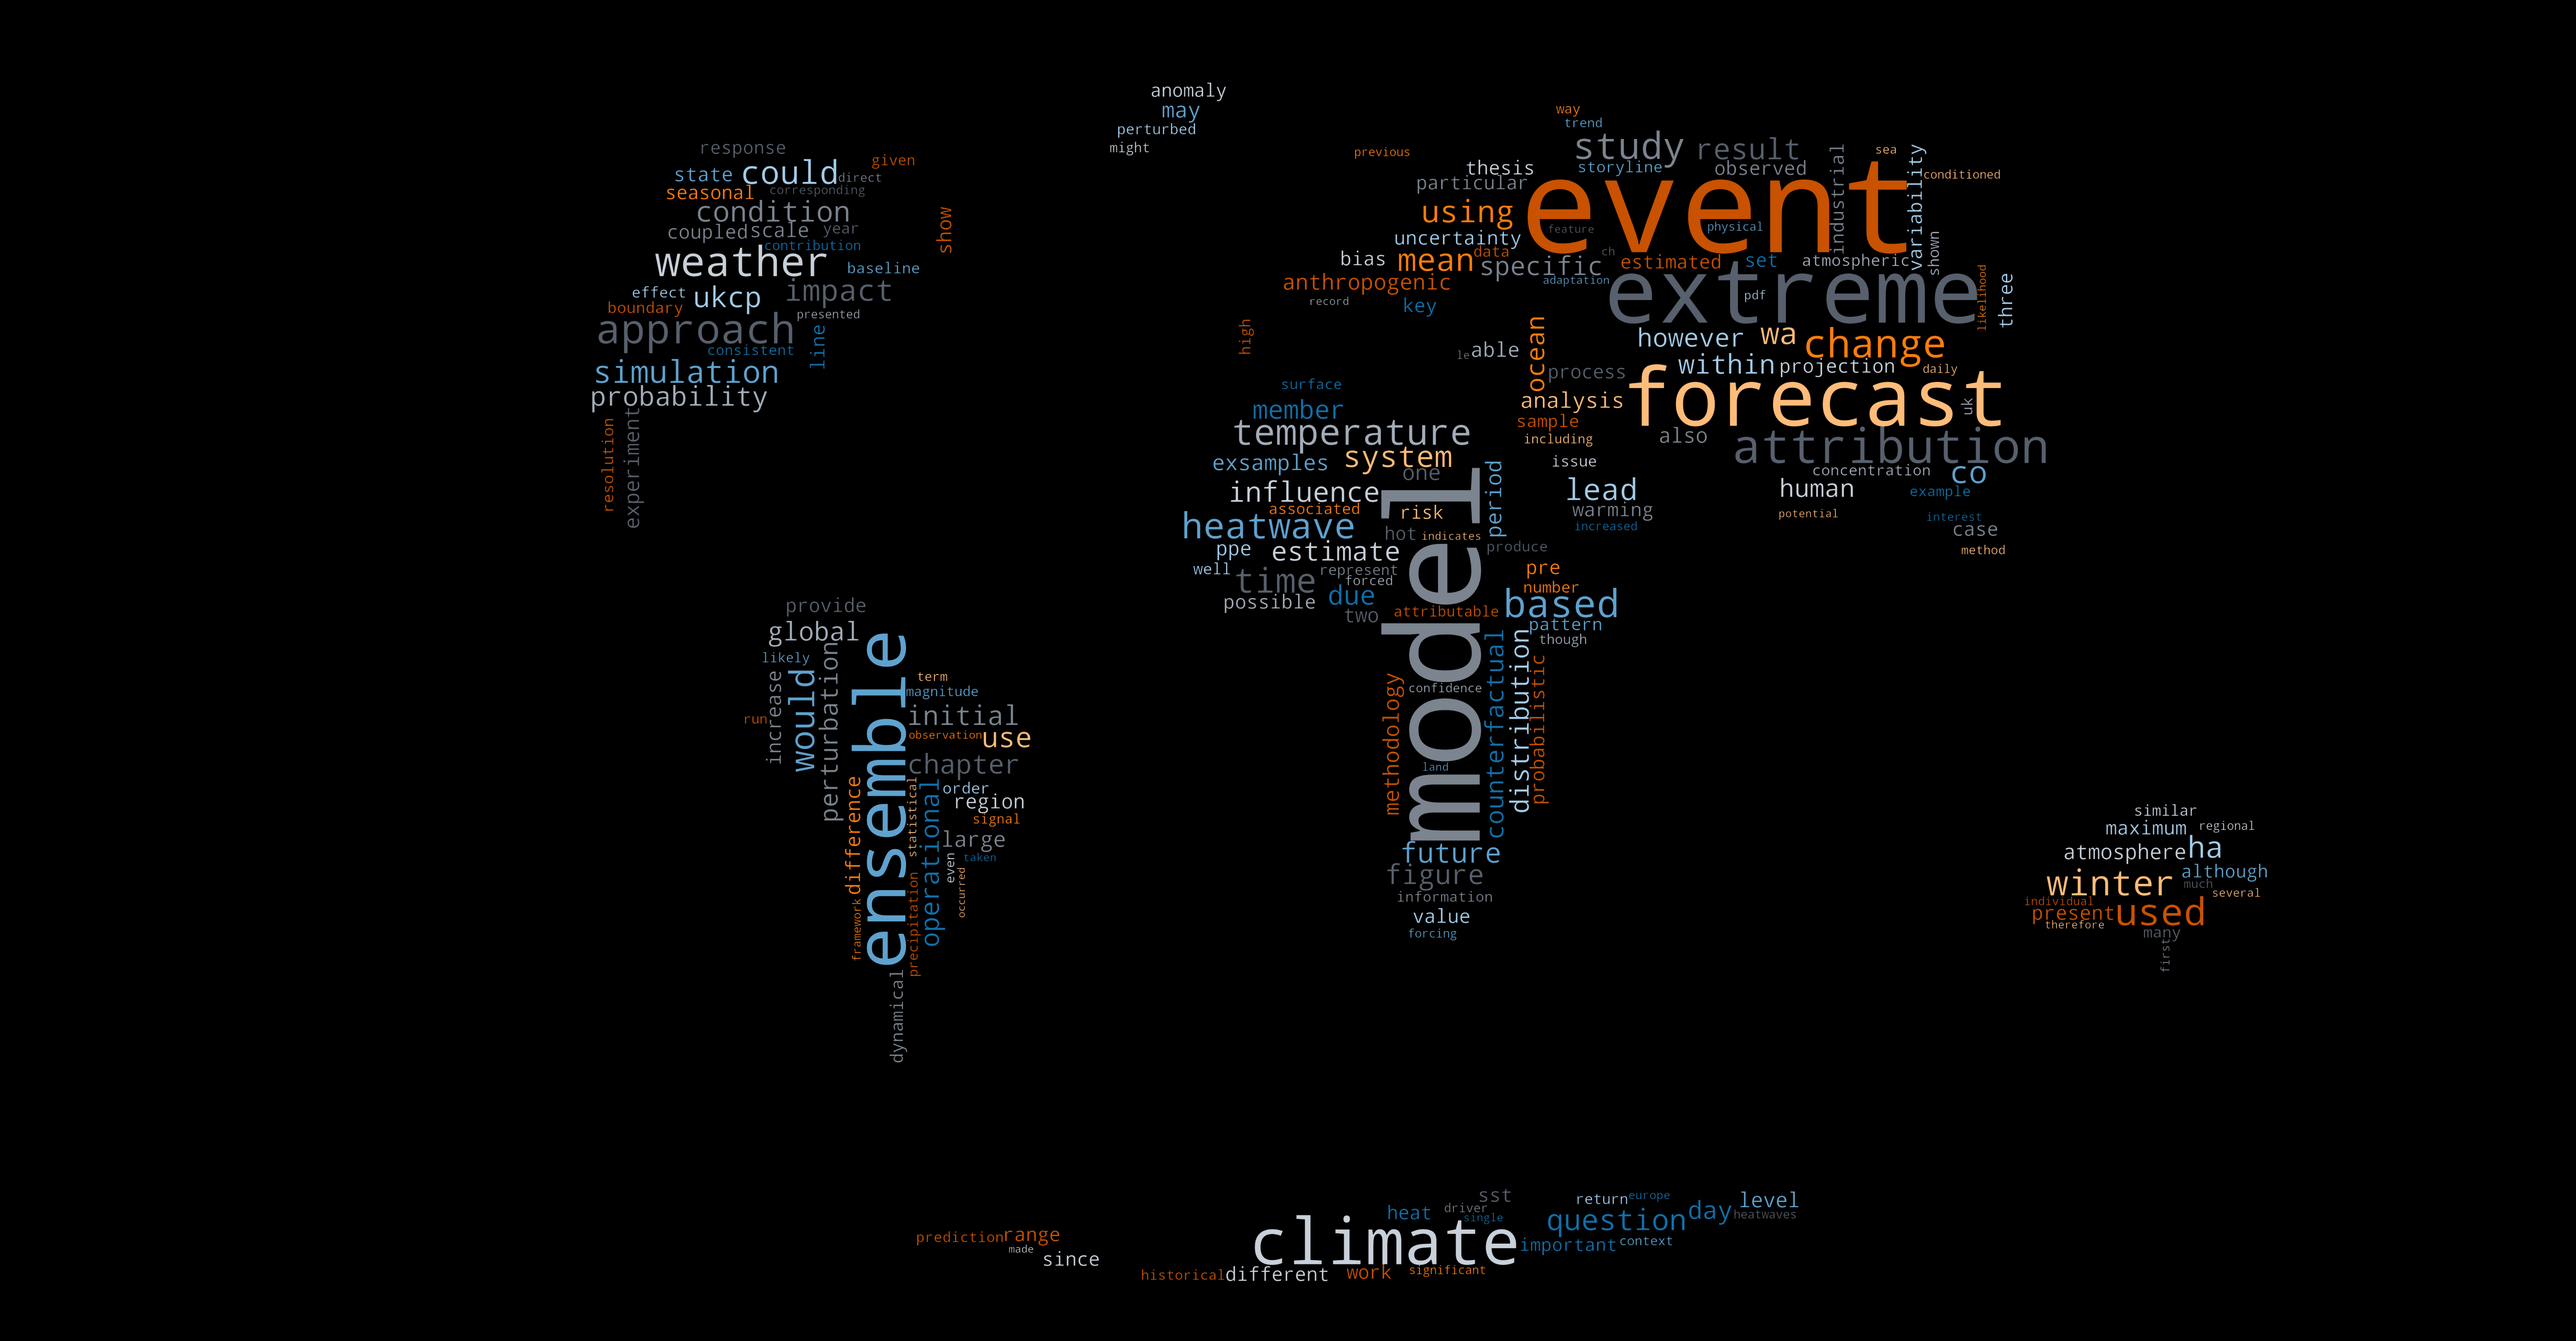

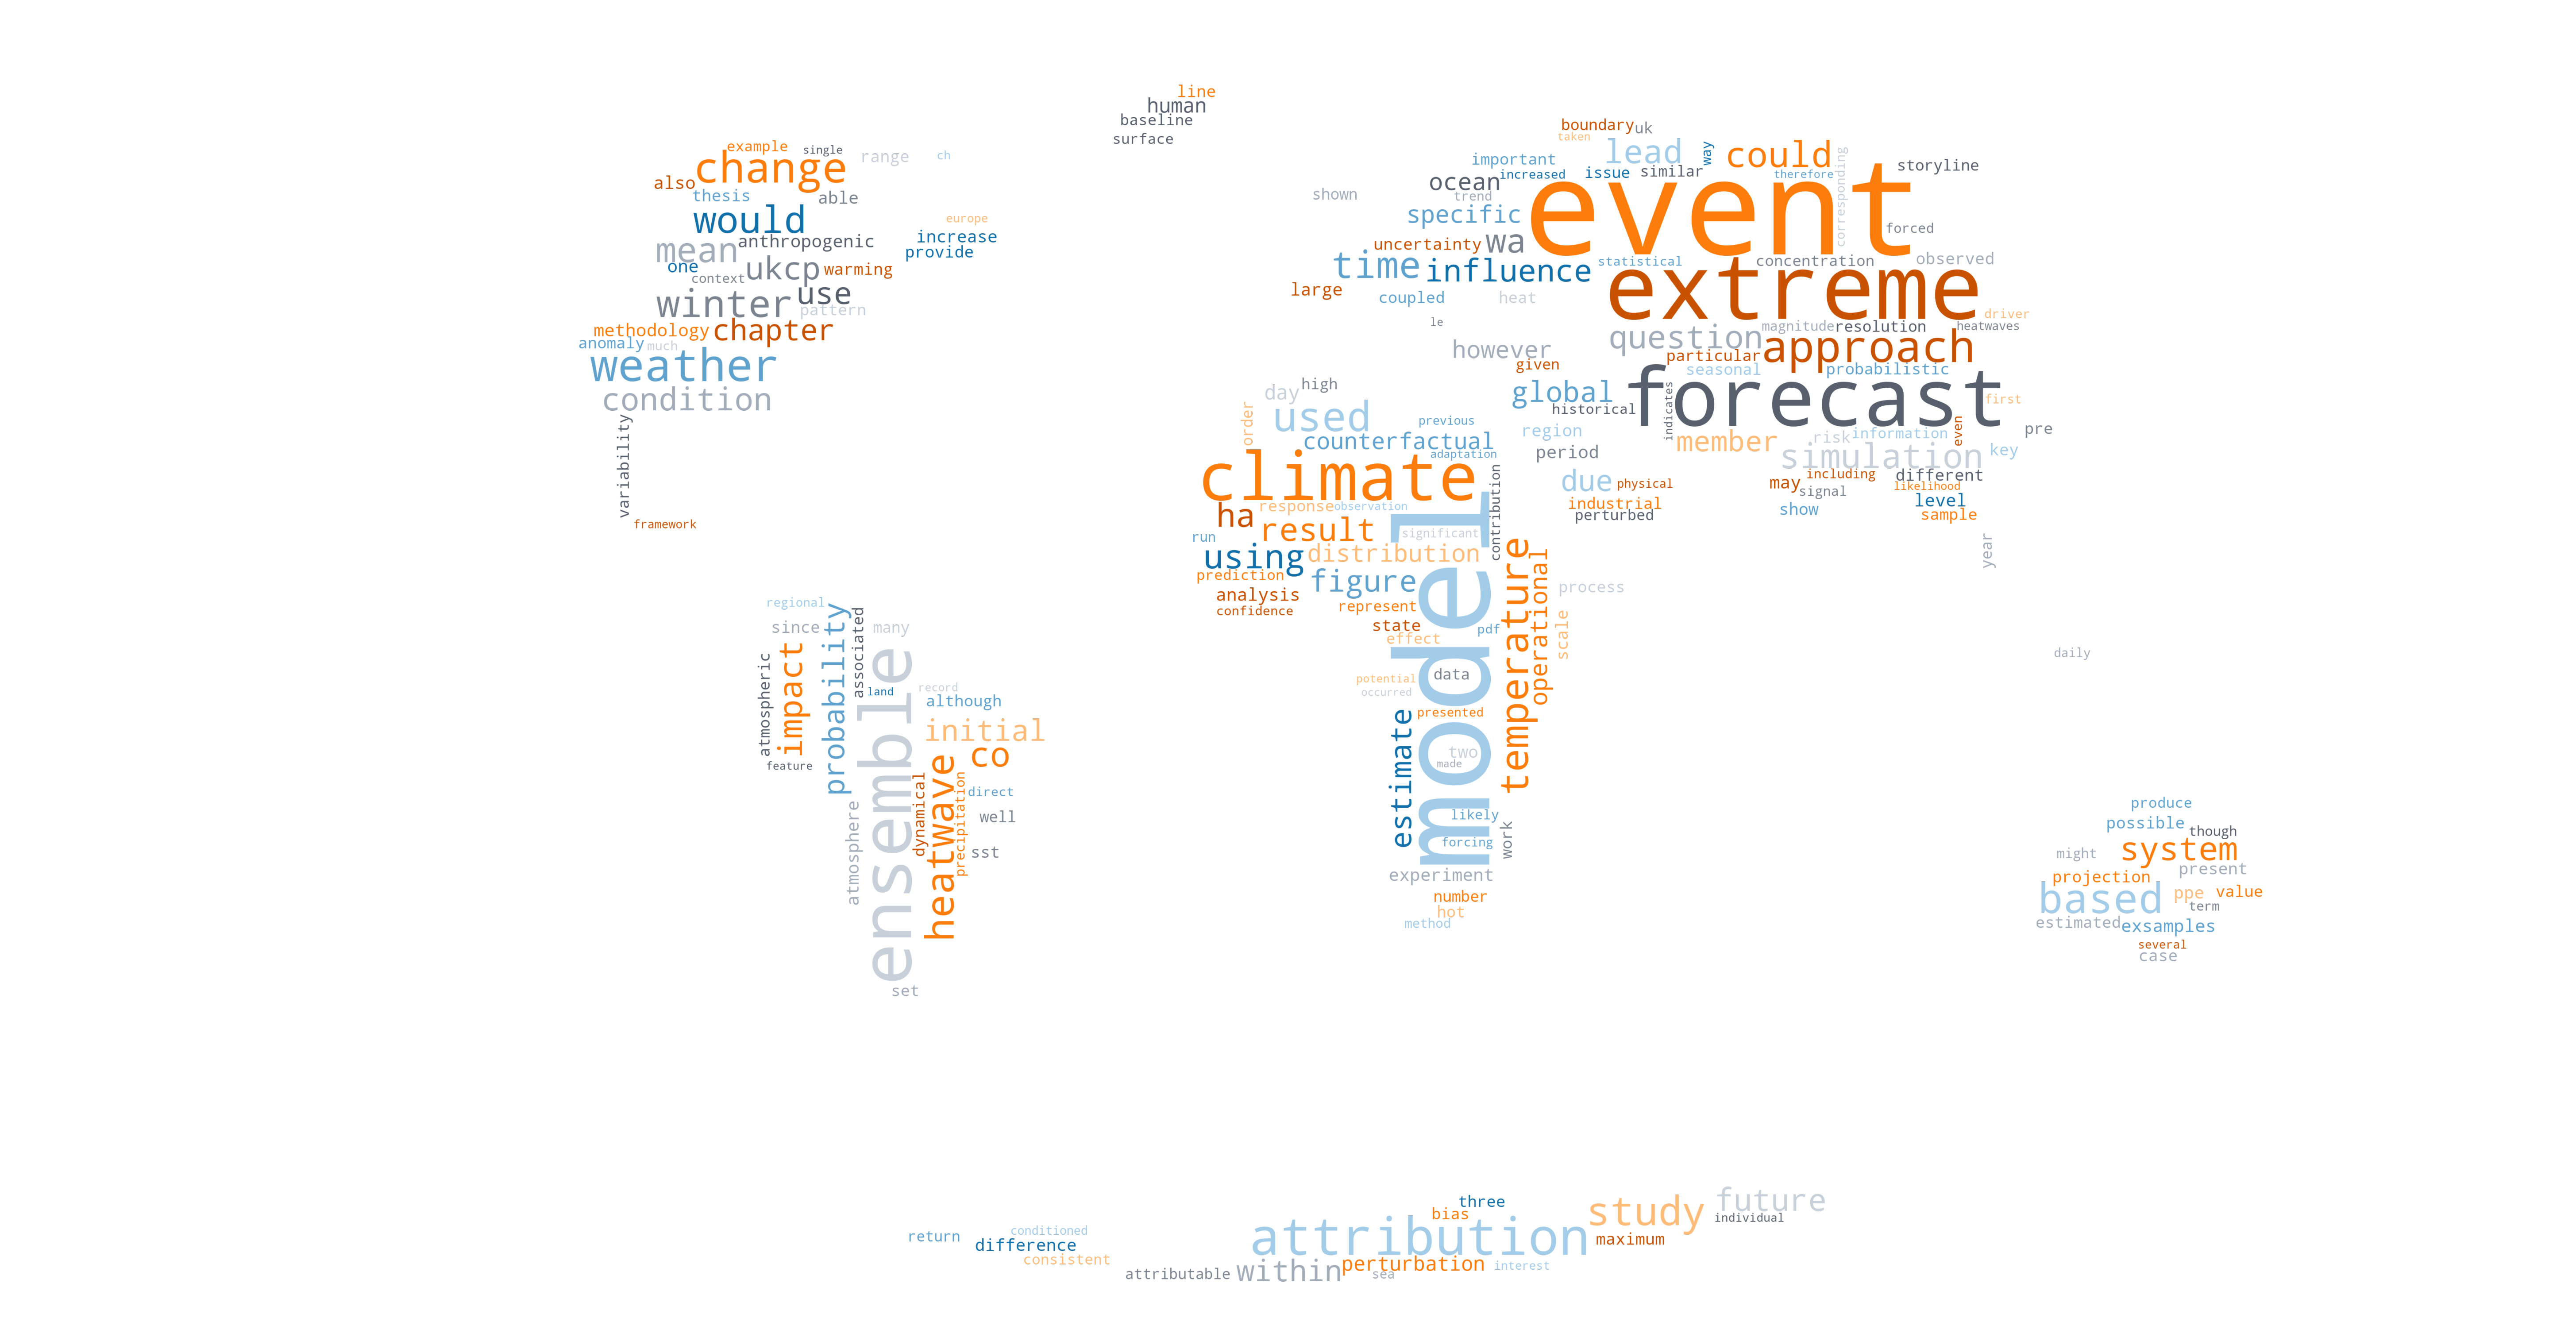

In [5]:
## set up generation of three different backgrounds:
bg_clrs = dict(white=(1,1,1,1),black=(0,0,0,1),transparent=(0,0,0,0))

for bg,bgc in bg_clrs.items():
    
    stopwords = set(STOPWORDS)

    wc = WordCloud(background_color=bgc,
                   mode='RGBA',
                   max_words=200,
                   stopwords=stopwords, 
                   mask=lsm.values[::-1], 
                   colormap=get_palette.color_blind().to_mpl_cmap(),
    #                contour_width=10,
                   contour_color=(160,160,160,128))

    wc.generate_from_frequencies(wordcloud_dict)
    
    fig=plt.figure()

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    ## figure layout
    fig.dpi=img_dpi
    fig.patch.set_facecolor(bgc)

    [fig.savefig('./thesis-wordcloud-{}.{}'.format(bg,x),dpi=img_dpi,bbox_inches='tight') for x in ['png','pdf']]